# Gap junction-coupled FitzHugh-Nagumo Model

In [1]:
import brainpy as bp
import brainpy.math as bm

# bp.math.set_platform('cpu')
bp.math.enable_x64()
bp.__version__

'2.4.1'

In [2]:
class GJCoupledFHN(bp.DynamicalSystem):
  def __init__(self, num=2, method='exp_auto'):
    super(GJCoupledFHN, self).__init__()

    # parameters
    self.num = num
    self.a = 0.7
    self.b = 0.8
    self.tau = 12.5
    self.gjw = 0.0001

    # variables
    self.V = bm.Variable(bm.random.uniform(-2, 2, num))
    self.w = bm.Variable(bm.random.uniform(-2, 2, num))
    self.Iext = bm.Variable(bm.zeros(num))

    # functions
    self.int_V = bp.odeint(self.dV, method=method)
    self.int_w = bp.odeint(self.dw, method=method)

  def dV(self, V, t, w, Iext=0.):
    gj = (V.reshape((-1, 1)) - V).sum(axis=0) * self.gjw
    dV = V - V * V * V / 3 - w + Iext + gj
    return dV

  def dw(self, w, t, V):
    dw = (V + self.a - self.b * w) / self.tau
    return dw

  def update(self, tdi):
    self.V.value = self.int_V(self.V, tdi.t, self.w, self.Iext, tdi.dt)
    self.w.value = self.int_w(self.w, tdi.t, self.V, tdi.dt)

In [3]:
def analyze_net(num=2, gjw=0.01, Iext=bm.asarray([0., 0.6])):
    assert isinstance(Iext, (int, float)) or (len(Iext) == num)
    
    model = GJCoupledFHN(num)
    model.gjw = gjw
    model.Iext[:] = Iext
    
    # simulation
    runner = bp.DSRunner(model, monitors=['V'])
    runner.run(300.)
    bp.visualize.line_plot(runner.mon.ts, runner.mon.V, legend='V',
                           plot_ids=list(range(model.num)), show=True)

    # analysis
    finder = bp.analysis.SlowPointFinder(f_cell=model,
                                         target_vars={'V': model.V, 'w': model.w})
    finder.find_fps_with_gd_method(
      candidates={'V': bm.random.normal(0., 2., (1000, model.num)),
                  'w': bm.random.normal(0., 2., (1000, model.num))},
      tolerance=1e-5,
      num_batch=200,
      optimizer=bp.optim.Adam(lr=bp.optim.ExponentialDecay(0.05, 1, 0.9999)),
    )
    finder.filter_loss(1e-8)
    finder.keep_unique()

    print('fixed_points: ', finder.fixed_points)
    print('losses:', finder.losses)

    _ = finder.compute_jacobians(finder.fixed_points, plot=True)

## 4D system

  0%|          | 0/3000 [00:00<?, ?it/s]

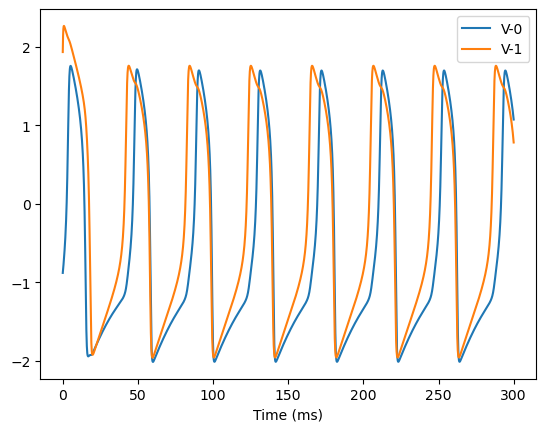

Optimizing with Adam(lr=ExponentialDecay(0.05, decay_steps=1, decay_rate=0.9999), last_call=-1), beta1=0.9, beta2=0.999, eps=1e-08) to find fixed points:
    Batches 1-200 in 0.44 sec, Training loss 0.0002920605
    Batches 201-400 in 0.30 sec, Training loss 0.0002164800
    Batches 401-600 in 0.30 sec, Training loss 0.0001641931
    Batches 601-800 in 0.27 sec, Training loss 0.0001261083
    Batches 801-1000 in 0.32 sec, Training loss 0.0000981229
    Batches 1001-1200 in 0.33 sec, Training loss 0.0000773020
    Batches 1201-1400 in 0.29 sec, Training loss 0.0000615549
    Batches 1401-1600 in 0.29 sec, Training loss 0.0000494929
    Batches 1601-1800 in 0.27 sec, Training loss 0.0000401365
    Batches 1801-2000 in 0.27 sec, Training loss 0.0000328117
    Batches 2001-2200 in 0.27 sec, Training loss 0.0000270381
    Batches 2201-2400 in 0.29 sec, Training loss 0.0000224743
    Batches 2401-2600 in 0.30 sec, Training loss 0.0000188838
    Batches 2601-2800 in 0.27 sec, Training loss 0.

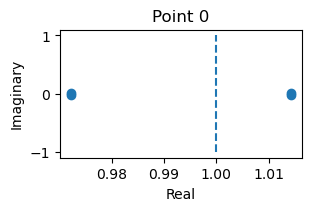

In [4]:
analyze_net(num=2, gjw=0.1, Iext=bm.asarray([0., 0.6]))

  0%|          | 0/3000 [00:00<?, ?it/s]

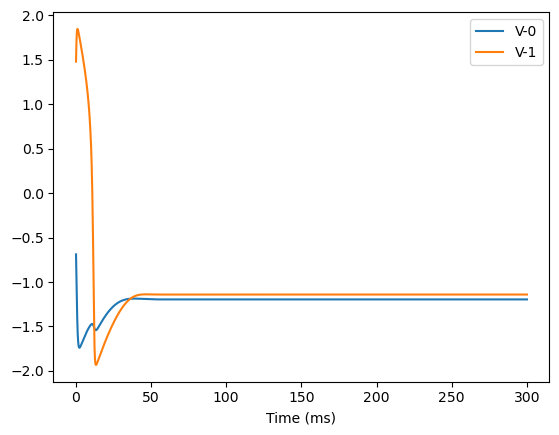

Optimizing with Adam(lr=ExponentialDecay(0.05, decay_steps=1, decay_rate=0.9999), last_call=-1), beta1=0.9, beta2=0.999, eps=1e-08) to find fixed points:
    Batches 1-200 in 0.41 sec, Training loss 0.0003050238
    Batches 201-400 in 0.31 sec, Training loss 0.0002300996
    Batches 401-600 in 0.32 sec, Training loss 0.0001799595
    Batches 601-800 in 0.31 sec, Training loss 0.0001435179
    Batches 801-1000 in 0.35 sec, Training loss 0.0001159723
    Batches 1001-1200 in 0.34 sec, Training loss 0.0000947193
    Batches 1201-1400 in 0.29 sec, Training loss 0.0000779911
    Batches 1401-1600 in 0.31 sec, Training loss 0.0000646832
    Batches 1601-1800 in 0.38 sec, Training loss 0.0000540572
    Batches 1801-2000 in 0.31 sec, Training loss 0.0000454388
    Batches 2001-2200 in 0.29 sec, Training loss 0.0000384459
    Batches 2201-2400 in 0.28 sec, Training loss 0.0000326713
    Batches 2401-2600 in 0.29 sec, Training loss 0.0000279430
    Batches 2601-2800 in 0.30 sec, Training loss 0.

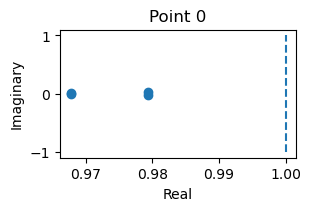

In [5]:
analyze_net(num=2, gjw=0.1, Iext=bm.asarray([0., 0.1]))

## 8D system

  0%|          | 0/3000 [00:00<?, ?it/s]

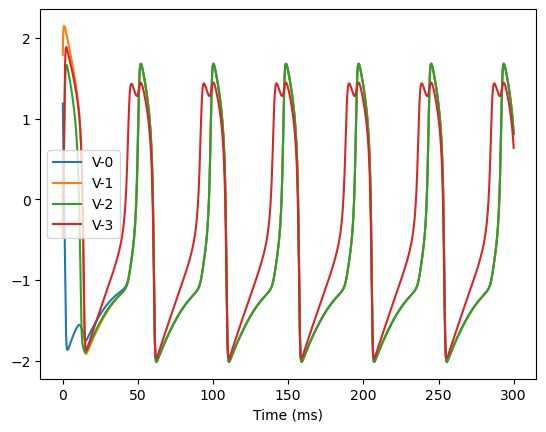

Optimizing with Adam(lr=ExponentialDecay(0.05, decay_steps=1, decay_rate=0.9999), last_call=-1), beta1=0.9, beta2=0.999, eps=1e-08) to find fixed points:
    Batches 1-200 in 0.40 sec, Training loss 0.0003074501
    Batches 201-400 in 0.31 sec, Training loss 0.0002238882
    Batches 401-600 in 0.29 sec, Training loss 0.0001729802
    Batches 601-800 in 0.33 sec, Training loss 0.0001365991
    Batches 801-1000 in 0.32 sec, Training loss 0.0001094897
    Batches 1001-1200 in 0.32 sec, Training loss 0.0000887693
    Batches 1201-1400 in 0.30 sec, Training loss 0.0000726531
    Batches 1401-1600 in 0.35 sec, Training loss 0.0000598970
    Batches 1601-1800 in 0.30 sec, Training loss 0.0000497622
    Batches 1801-2000 in 0.31 sec, Training loss 0.0000416278
    Batches 2001-2200 in 0.31 sec, Training loss 0.0000350402
    Batches 2201-2400 in 0.28 sec, Training loss 0.0000296583
    Batches 2401-2600 in 0.40 sec, Training loss 0.0000252454
    Batches 2601-2800 in 0.38 sec, Training loss 0.

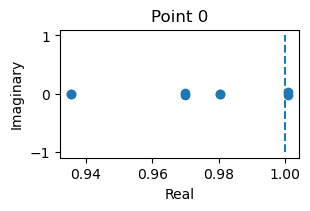

In [6]:
analyze_net(num=4, gjw=0.1, Iext=bm.asarray([0., 0., 0., 0.6]))